<h1><center>Clustering Lisbon neighbourhoods</center></h1>

# 1 Introduction

The aim of this project is to recommend which neighbourhood of Lisbon is the best location to open a new office, analysing location data – to explore and compare neighborhoods, using Foursquare API and K-means clustering algorithm.

# 2 Data acquisition and pre-processing
## 2.1 Required libraries

In [0]:
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors
from sklearn.cluster import KMeans # import k-means from clustering stage
import folium # map rendering library

## 2.2 Data scrapped from Wikipedia

In [2]:
import sys
!{sys.executable} -m pip install wikipedia

  Created wheel for wikipedia: filename=wikipedia-1.4.0-cp36-none-any.whl size=11686 sha256=cb69337ee399d62e1a7f93ec0556d9badbf3de570a94488a99584e361c54a567
  Stored in directory: /root/.cache/pip/wheels/87/2a/18/4e471fd96d12114d16fe4a446d00c3b38fb9efcb744bd31f4a
Successfully built wikipedia


In [0]:
import wikipedia as wp
wp.set_lang("pt") 
html = wp.page("Lista_de_freguesias_de_Lisboa").html().encode("UTF-8")
df = pd.read_html(html)[0]
df.to_csv('lisboa_data.csv',header=1,index=False)

In [4]:
# transform the data into a pandas dataframe

df = pd.read_csv('lisboa_data.csv')
df.head(3)

,Freguesias atuais,Freguesias atuais.1,Freguesias atuais.2,Freguesias atuais.3,Freguesias atuais.4,Freguesias antigas,Freguesias antigas.1,Freguesias antigas.2,Freguesias antigas.3,Freguesias antigas.4
0,N.Âº[nota 1],BrasÃ£o,Freguesia (Zona)[1],PopulaÃ§Ã£o[4],Ãrea(kmÂ²)[3],N.Âº[nota 2],BrasÃ£o,Freguesia (Bairro),PopulaÃ§Ã£o(2011)[6],Ãrea(kmÂ²)[5]
1,1,NaN,Ajuda (Ocidental),15 617,288,1,NaN,Ajuda[nota 3] (2.Âº Bairro),15 584,286
2,2,NaN,AlcÃ¢ntara (Ocidental),13 943,"5,07[nota 4]",2,NaN,AlcÃ¢ntara[nota 5] (2.Âº Bairro),13 943,444


In [0]:
# cleaning the dataframe: remove the useless columns and remove duplicates

df.drop(df.index[0], inplace=True)
df.drop_duplicates(subset = "Freguesias atuais", keep = 'first' , inplace = True)

In [0]:
# cleaning the dataframe: new column names

df.rename(columns={'Freguesias atuais': 'Number','Freguesias atuais.2': 'Neighbourhood'}, inplace=True)

In [7]:
# there are 24 neighbourhoods in Lisbon

df.reset_index(drop=True)
lisbon_df=df[['Number','Neighbourhood']]
lisbon_df.describe()

,Number,Neighbourhood
count,24,24
unique,24,24
top,33,Avenidas Novas (Centro)
freq,1,1


In [8]:
lisbon_df['Number']=lisbon_df['Number'].astype(str).astype(int)
lisbon_df.dtypes

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Number            int64
Neighbourhood    object
dtype: object

### 3.3 Latitude and Longitude from a csv file

In [0]:
url = 'https://raw.githubusercontent.com/mdsl22/Coursera_Capstone/master/Geo_Lisbon.csv'

In [10]:
df_geo = pd.read_csv(url)
df_geo.head(3)

,Number,Latitude,Longitude,Neighbourhood_name
0,1,38.707500,-9.198333,Ajuda
1,2,38.706389,-9.174167,Alcantara
2,54,38.746944,-9.136111,Alvalade


In [11]:
df_geo.dtypes

Number                  int64
Latitude              float64
Longitude             float64
Neighbourhood_name     object
dtype: object

In [12]:
# Create Latitude and Longitude columns in the dataframe lisbon
lisbon_df['Latitude'] = np.nan
lisbon_df['Longitude'] = np.nan

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
# For each Number in lisbon find the corresponding coordinates in df_geo and assign it to lisbon_df

for idx in lisbon_df.index:
    cord_idx = df_geo['Number'] == lisbon_df.loc[idx, 'Number']
    lisbon_df.at[idx, 'Latitude'] = df_geo.loc[cord_idx, 'Latitude'].values
    lisbon_df.at[idx, 'Longitude'] = df_geo.loc[cord_idx, 'Longitude'].values
 
lisbon_df.head(3)

,Number,Neighbourhood,Latitude,Longitude
1,1,Ajuda (Ocidental),38.707500,-9.198333
2,2,AlcÃ¢ntara (Ocidental),38.706389,-9.174167
3,54,Alvalade (Centro),38.746944,-9.136111


In [14]:
# since the Wikipedia names are too long and with some errors we will use an alternative column for the neighbourhood names

df_lisbon=df_geo[['Number','Neighbourhood_name','Latitude','Longitude']]
df_lisbon

,Number,Neighbourhood_name,Latitude,Longitude
0,1,Ajuda,38.707500,-9.198333
1,2,Alcantara,38.706389,-9.174167
2,54,Alvalade,38.746944,-9.136111
3,55,Areeiro,38.740278,-9.128056
4,56,Arroios,38.728889,-9.138889
5,57,Avenidas Novas,38.738889,-9.145833
6,7,Beato,38.734722,-9.105833
7,58,Belem,38.700000,-9.200000
8,8,Benfica,38.751111,-9.202222
9,59,Campo de Ourique,38.715278,-9.166944


In [15]:
df_lisbon.dtypes

Number                  int64
Neighbourhood_name     object
Latitude              float64
Longitude             float64
dtype: object

# 3 Methodology
### 3.1 Exploratory data analysis


In [16]:
# Geographical coordinates of Lisbon

address = 'Lisbon'

geolocator = Nominatim(user_agent="coursera")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Lisbon are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Lisbon are 38.7077507, -9.1365919.


In [17]:
# create map of Lisbon using latitude and longitude values
map_lisbon = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for latitude, longitude, borough, neighborhood in zip(df_lisbon['Latitude'], df_lisbon['Longitude'], df_lisbon['Number'], df_lisbon['Neighbourhood_name']):
    label = '{}, {}'.format(borough, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=8,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lisbon)  

map_lisbon

### 3.2 Foursquare


In [18]:
# Foursquare credentials and version

CLIENT_ID = 'client ID' # your Foursquare ID
CLIENT_SECRET = 'client secret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: S52NPP2NCWKLHPGXFJLLGLUJEROEI32DGTYBGUDOM0XKLYGB
CLIENT_SECRET:KVF0LGIYW1FNVD1WHD30WC1EGWMMX5ISCAACN2YJTTBVM2CJ


In [19]:
df_lisbon.columns

Index(['Number', 'Neighbourhood_name', 'Latitude', 'Longitude'], dtype='object')

In [20]:
# Get the venues that are in Benfica (8) within a radius of 500 meters

df_lisbon.set_index('Number', inplace = True) 
neighborhood_latitude = df_lisbon.iloc[8]['Latitude']
neighborhood_longitude = df_lisbon.iloc[8]['Longitude']

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=S52NPP2NCWKLHPGXFJLLGLUJEROEI32DGTYBGUDOM0XKLYGB&client_secret=KVF0LGIYW1FNVD1WHD30WC1EGWMMX5ISCAACN2YJTTBVM2CJ&v=20180605&ll=38.751111,-9.202222&radius=500&limit=100'

In [0]:
# get request and examine the resutls

results = requests.get(url).json()

In [0]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [23]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,A Padaria Portuguesa,Bakery,38.750727,-9.201863
1,Teatro Turim,Theater,38.750702,-9.202288
2,Mata de Benfica - Parque Silva Porto,Park,38.749030,-9.204727
3,Com Calma,Coffee Shop,38.751835,-9.199237
4,A Travessa do Rio,Portuguese Restaurant,38.750511,-9.198650


In [24]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

44 venues were returned by Foursquare.


### 3.3 Explore the neighbourhoods

In [0]:
# Function that repeat the same process to all the neighborhoods

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [26]:
# run the above function on each neighbourhood and create a new dataframe called venues
venues = getNearbyVenues(names=df_lisbon['Neighbourhood_name'],latitudes=df_lisbon['Latitude'],longitudes=df_lisbon['Longitude'])

Ajuda
Alcantara
Alvalade
Areeiro
Arroios
Avenidas Novas
Beato
Belem
Benfica
Campo de Ourique
Campolide
Carnide
Estrela
Lumiar
Marvila
Misericordia
Olivais
Parque das nacoes
Penha de Franca
Santa Clara
Santa Maria Maior
Santo Antonio
Sao Domingos de Benfica
Sao Vicente


In [27]:
print(venues.shape)
venues.head()

(1015, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ajuda,38.7075,-9.198333,Palácio Nacional da Ajuda,38.707653,-9.197758,Historic Site
1,Ajuda,38.7075,-9.198333,Restaurante Andorinhas,38.704911,-9.199349,Restaurant
2,Ajuda,38.7075,-9.198333,Páteo Alfacinha,38.706537,-9.194202,Restaurant
3,Ajuda,38.7075,-9.198333,Jardim Botânico da Ajuda,38.706430,-9.201222,Botanical Garden
4,Ajuda,38.7075,-9.198333,Churrasqueira do Marquês,38.703996,-9.199402,BBQ Joint


In [28]:
venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Ajuda,7,7,7,7,7,7
Alcantara,23,23,23,23,23,23
Alvalade,41,41,41,41,41,41
Areeiro,27,27,27,27,27,27
Arroios,33,33,33,33,33,33
Avenidas Novas,85,85,85,85,85,85
Beato,8,8,8,8,8,8
Belem,50,50,50,50,50,50
Benfica,44,44,44,44,44,44


In [0]:
df_graph = venues.groupby('Neighborhood').count()

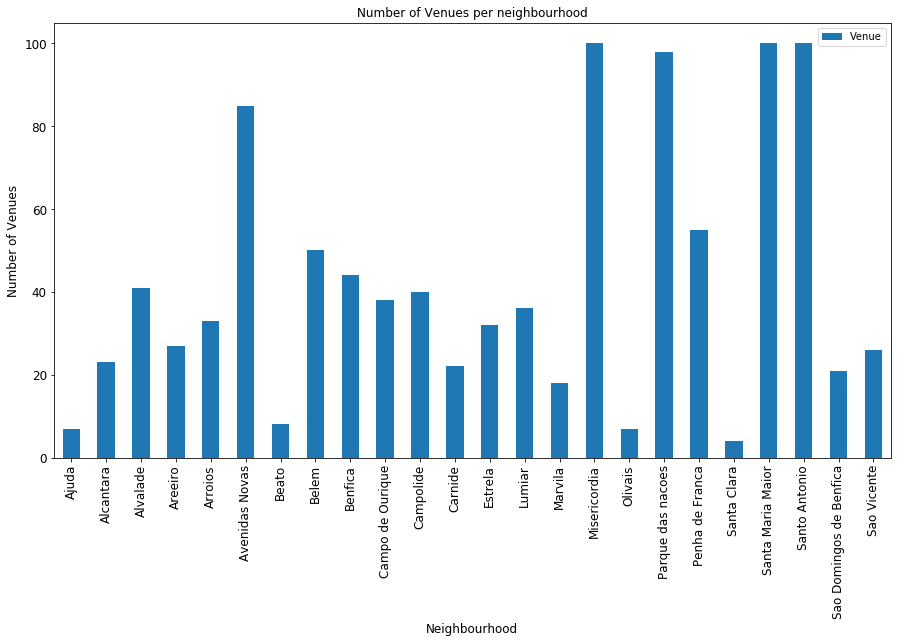

In [30]:
import matplotlib.pyplot as plt
ax = df_graph[['Venue']].plot(kind='bar', title ="Number of Venues per neighbourhood", figsize=(15, 8), legend=True, fontsize=12)
ax.set_xlabel("Neighbourhood", fontsize=12)
ax.set_ylabel("Number of Venues", fontsize=12)
plt.show()

In [31]:
print('There are {} unique categories.'.format(len(venues['Venue Category'].unique())))

There are 168 unique categories.


In [32]:
# one hot encoding
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Neighborhood'] = venues['Neighborhood'] 

onehot.head()

,Accessories Store,African Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Bistro,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Bus Station,Butcher,Cable Car,Café,Cantonese Restaurant,Capitol Building,Casino,Castle,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,...,Ramen Restaurant,Resort,Restaurant,Road,Roof Deck,Russian Restaurant,Salad Place,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Zoo
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
onehot.shape

(1015, 168)

In [34]:
grouped = onehot.groupby('Neighborhood').mean().reset_index()
grouped

,Neighborhood,Accessories Store,African Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Bistro,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Bus Station,Butcher,Cable Car,Café,Cantonese Restaurant,Capitol Building,Casino,Castle,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,...,Ramen Restaurant,Resort,Restaurant,Road,Roof Deck,Russian Restaurant,Salad Place,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Zoo
0,Ajuda,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.142857,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000,0.00,0.000000,0.00,0.00,0.000000,0.000,0.00,0.000000,0.00,0.000000,...,0.00,0.00,0.428571,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000
1,Alcantara,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.043478,0.000000,0.043478,0.000000,0.000000,0.043478,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000,0.00,0.000000,0.00,0.00,0.000000,0.000,0.00,0.000000,0.00,0.043478,...,0.00,0.00,0.043478,0.00,0.00,0.00,0.00,0.000000,0.000000,0.043478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.043478,0.043478,0.00,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000
2,Alvalade,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.048780,0.000000,0.048780,0.024390,0.000000,0.000000,0.000000,0.000000,0.073171,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.02439,0.02439,0.000000,0.097561,0.000,0.00,0.000000,0.00,0.00,0.000000,0.000,0.00,0.000000,0.00,0.048780,...,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.024390,0.024390,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.024390,0.000000,0.00,0.000000,0.000000,0.000000,0.02439,0.024390,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000
3,Areeiro,0.00,0.00,0.000000,0.000000,0.00,0.037037,0.037037,0.000000,0.000000,0.037037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.037037,0.000,0.00,0.000000,0.00,0.00,0.037037,0.000,0.00,0.000000,0.00,0.037037,...,0.00,0.00,0.037037,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.037037,0.037037,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.037037,0.00000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.037037,0.000000,0.00,0.000000
4,Arroios,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.030303,0.030303,0.060606,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.030303,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.030303,0.000,0.00,0.000000,0.00,0.00,0.030303,0.000,0.00,0.000000,0.00,0.000000,...,0.00,0.00,0.030303,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [35]:
grouped.shape

(24, 168)

In [36]:
num_top_venues = 5

for hood in grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = grouped[grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Ajuda----
              venue  freq
0        Restaurant  0.43
1     Historic Site  0.14
2         BBQ Joint  0.14
3            Bakery  0.14
4  Botanical Garden  0.14


----Alcantara----
                      venue  freq
0     Portuguese Restaurant  0.22
1  Mediterranean Restaurant  0.09
2                     Plaza  0.04
3         Indian Restaurant  0.04
4               Pizza Place  0.04


----Alvalade----
                   venue  freq
0  Portuguese Restaurant  0.12
1                   Café  0.10
2              Bookstore  0.07
3            Coffee Shop  0.05
4         Ice Cream Shop  0.05


----Areeiro----
                   venue  freq
0  Portuguese Restaurant  0.15
1                  Hotel  0.15
2      Electronics Store  0.11
3             Restaurant  0.04
4            Flower Shop  0.04


----Arroios----
                           venue  freq
0                          Hotel  0.12
1          Portuguese Restaurant  0.12
2              Indian Restaurant  0.09
3                      

In [0]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [38]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = grouped['Neighborhood']

for ind in np.arange(grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ajuda,Restaurant,Historic Site,BBQ Joint,Bakery,Botanical Garden,Zoo,Exhibit,Food,Flower Shop,Flea Market
1,Alcantara,Portuguese Restaurant,Mediterranean Restaurant,Seafood Restaurant,Museum,Restaurant,Nightclub,Eastern European Restaurant,Supermarket,Sushi Restaurant,Beer Bar
2,Alvalade,Portuguese Restaurant,Café,Bookstore,Bakery,Ice Cream Shop,Coffee Shop,Electronics Store,Hotel,BBQ Joint,Gym / Fitness Center
3,Areeiro,Portuguese Restaurant,Hotel,Electronics Store,Tennis Court,Café,Restaurant,Chinese Restaurant,Sports Club,Stadium,Italian Restaurant
4,Arroios,Hotel,Portuguese Restaurant,Indian Restaurant,Hostel,Vegetarian / Vegan Restaurant,Bakery,Organic Grocery,Chinese Restaurant,Restaurant,Cultural Center
5,Avenidas Novas,Restaurant,Portuguese Restaurant,Hotel,Italian Restaurant,Bakery,Café,Vegetarian / Vegan Restaurant,Gym / Fitness Center,Burger Joint,Brewery
6,Beato,Restaurant,Historic Site,Tapas Restaurant,Cantonese Restaurant,Brewery,Gym / Fitness Center,Empanada Restaurant,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
7,Belem,Portuguese Restaurant,Bakery,Garden,History Museum,Café,Restaurant,BBQ Joint,Pizza Place,Sandwich Place,Capitol Building
8,Benfica,Portuguese Restaurant,Café,Seafood Restaurant,Coffee Shop,Bakery,Park,Restaurant,Breakfast Spot,Sushi Restaurant,Market
9,Campo de Ourique,Portuguese Restaurant,Coffee Shop,Bakery,Bar,Restaurant,Seafood Restaurant,Market,Italian Restaurant,Sandwich Place,Café


## 4 Cluster neighbourhoods

In [39]:
# set number of clusters
kclusters = 5

grouped_clustering = grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 3, 0, 0, 0, 0, 1, 3, 3, 3], dtype=int32)

In [40]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

merged = df_lisbon

# merge neighborhoods_venues_sorted with df_lisbon to add latitude/longitude for each neighborhood
merged = merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood_name')

merged.head() # check the last columns!

,Neighbourhood_name,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Number,,,,,,,,,,,,,,
1,Ajuda,38.707500,-9.198333,1,Restaurant,Historic Site,BBQ Joint,Bakery,Botanical Garden,Zoo,Exhibit,Food,Flower Shop,Flea Market
2,Alcantara,38.706389,-9.174167,3,Portuguese Restaurant,Mediterranean Restaurant,Seafood Restaurant,Museum,Restaurant,Nightclub,Eastern European Restaurant,Supermarket,Sushi Restaurant,Beer Bar
54,Alvalade,38.746944,-9.136111,0,Portuguese Restaurant,Café,Bookstore,Bakery,Ice Cream Shop,Coffee Shop,Electronics Store,Hotel,BBQ Joint,Gym / Fitness Center
55,Areeiro,38.740278,-9.128056,0,Portuguese Restaurant,Hotel,Electronics Store,Tennis Court,Café,Restaurant,Chinese Restaurant,Sports Club,Stadium,Italian Restaurant
56,Arroios,38.728889,-9.138889,0,Hotel,Portuguese Restaurant,Indian Restaurant,Hostel,Vegetarian / Vegan Restaurant,Bakery,Organic Grocery,Chinese Restaurant,Restaurant,Cultural Center


In [41]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Latitude'], merged['Longitude'], merged['Neighbourhood_name'], merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5 Examine Clusters

In [42]:
# Cluster 0

merged.loc[merged['Cluster Labels'] == 0, merged.columns[[0] + list(range(4, merged.shape[1]))]]

,Neighbourhood_name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Number,,,,,,,,,,,
54,Alvalade,Portuguese Restaurant,Café,Bookstore,Bakery,Ice Cream Shop,Coffee Shop,Electronics Store,Hotel,BBQ Joint,Gym / Fitness Center
55,Areeiro,Portuguese Restaurant,Hotel,Electronics Store,Tennis Court,Café,Restaurant,Chinese Restaurant,Sports Club,Stadium,Italian Restaurant
56,Arroios,Hotel,Portuguese Restaurant,Indian Restaurant,Hostel,Vegetarian / Vegan Restaurant,Bakery,Organic Grocery,Chinese Restaurant,Restaurant,Cultural Center
57,Avenidas Novas,Restaurant,Portuguese Restaurant,Hotel,Italian Restaurant,Bakery,Café,Vegetarian / Vegan Restaurant,Gym / Fitness Center,Burger Joint,Brewery
10,Campolide,Restaurant,Bakery,Hotel,Portuguese Restaurant,Seafood Restaurant,Electronics Store,Movie Theater,Shopping Mall,Scenic Lookout,Fast Food Restaurant
18,Lumiar,Fast Food Restaurant,Café,Pizza Place,Bakery,Soccer Stadium,Restaurant,Chinese Restaurant,Japanese Restaurant,Sushi Restaurant,Supermarket
62,Parque das nacoes,Portuguese Restaurant,Sushi Restaurant,Restaurant,Chinese Restaurant,Ice Cream Shop,Electronics Store,Coffee Shop,Burger Joint,Café,Seafood Restaurant
63,Penha de Franca,Portuguese Restaurant,Café,Hotel,Snack Place,Supermarket,Hostel,Chinese Restaurant,Bakery,Scenic Lookout,Indian Restaurant
65,Santa Maria Maior,Portuguese Restaurant,Hotel,Café,Restaurant,Wine Bar,Indian Restaurant,Ice Cream Shop,Coffee Shop,Scenic Lookout,Hostel


In [43]:
# Cluster 1

merged.loc[merged['Cluster Labels'] == 1, merged.columns[[0] + list(range(4, merged.shape[1]))]]

,Neighbourhood_name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Number,,,,,,,,,,,
1,Ajuda,Restaurant,Historic Site,BBQ Joint,Bakery,Botanical Garden,Zoo,Exhibit,Food,Flower Shop,Flea Market
7,Beato,Restaurant,Historic Site,Tapas Restaurant,Cantonese Restaurant,Brewery,Gym / Fitness Center,Empanada Restaurant,Fish & Chips Shop,Fast Food Restaurant,Farmers Market


In [44]:
# Cluster 2

merged.loc[merged['Cluster Labels'] == 2, merged.columns[[0] + list(range(4, merged.shape[1]))]]

,Neighbourhood_name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Number,,,,,,,,,,,
33,Olivais,Restaurant,Hostel,Café,Furniture / Home Store,BBQ Joint,Chinese Restaurant,Eastern European Restaurant,Farmers Market,Flower Shop,Flea Market


In [45]:
# Cluster 3

merged.loc[merged['Cluster Labels'] == 3, merged.columns[[0] + list(range(4, merged.shape[1]))]]

,Neighbourhood_name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Number,,,,,,,,,,,
2,Alcantara,Portuguese Restaurant,Mediterranean Restaurant,Seafood Restaurant,Museum,Restaurant,Nightclub,Eastern European Restaurant,Supermarket,Sushi Restaurant,Beer Bar
58,Belem,Portuguese Restaurant,Bakery,Garden,History Museum,Café,Restaurant,BBQ Joint,Pizza Place,Sandwich Place,Capitol Building
8,Benfica,Portuguese Restaurant,Café,Seafood Restaurant,Coffee Shop,Bakery,Park,Restaurant,Breakfast Spot,Sushi Restaurant,Market
59,Campo de Ourique,Portuguese Restaurant,Coffee Shop,Bakery,Bar,Restaurant,Seafood Restaurant,Market,Italian Restaurant,Sandwich Place,Café
11,Carnide,Portuguese Restaurant,Restaurant,Bakery,Café,Historic Site,Food,Mediterranean Restaurant,Garden,Sushi Restaurant,Tapas Restaurant
60,Estrela,Portuguese Restaurant,Café,Grocery Store,Steakhouse,Hostel,Supermarket,Hobby Shop,Ice Cream Shop,Garden,Japanese Restaurant
21,Marvila,Restaurant,Portuguese Restaurant,Art Gallery,Mediterranean Restaurant,Café,Nightclub,Motorcycle Shop,Pizza Place,Train Station,Argentinian Restaurant
61,Misericordia,Portuguese Restaurant,Bar,Café,Wine Bar,Hostel,Cocktail Bar,Restaurant,Breakfast Spot,Hotel,Bed & Breakfast
67,Sao Vicente,Portuguese Restaurant,Bakery,Café,Mediterranean Restaurant,Coffee Shop,Bistro,Other Nightlife,Plaza,Event Space,Flea Market


In [46]:
# Cluster 4

merged.loc[merged['Cluster Labels'] == 4, merged.columns[[0] + list(range(4, merged.shape[1]))]]

,Neighbourhood_name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Number,,,,,,,,,,,
64,Santa Clara,Portuguese Restaurant,Brewery,Gas Station,Exhibit,Food,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
